![Photo of Twitter from Business Insider article](https://i.insider.com/5d5fea4746552c5c523a3e03?width=1200&format=jpeg)

# Twitter Sentiment Analysis on Tech Brands

## Introduction

Sentiment analysis is a type of analysis derived from natural language processing that is beneficial to adapt for any company providing products and services for consumers. Using the [scikit-learn](https://scikit-learn.org/stable/index.html) and [NLTK library](http://www.nltk.org/index.html), we create a model that can predict the sentiment of a Twitter tweet based on its content. This model serves as a proof of concept that such predictions can be made based on the content of our data.

## Business Problem

Customer feedback is a crucial part of the business of providing consumer products and services, as without feedback, we would be left not knowing how best to improve our products to appeal to our existing consumer base and reach out further to more people. One way we could go about reviewing customer feedback data to further improve as a business is by using a sentiment analysis model, derived from machine learning algorithms and language processing to process the feelings of consumers based on text data. According to [MonkeyLearn](https://monkeylearn.com/), a company with a machine learning platform for text analysis, [sentiment analysis](https://monkeylearn.com/sentiment-analysis/) can benefit us as a company in a few ways: 

- We are able to **sort data at scale** -- instead of individually reviewing and sorting through thousands of social media posts and customer surveys, sentiment analysis models can help process huge amounts of data in an efficient and cost-effective way.
- With sentiment analysis models, we can perform **real-time analysis** during support conversations with customers over support channels or social media to  identify potential issues and address them as quickly as possible.
- A centralized sentiment analysis model would ensure that we can process our feedback data with **consistent criteria** so we can obtain more accurate, optimal insights.

By using sentiment analysis models that can sort through customer feedback and predict their sentiments, we can make decisions to maximize sales and customer satisfaction when launching new products and services, as well as track their feelings over time. That way, we can analyze feelings of our target audience towards our brand and make informed decisions to retain and possibly expand our consumer base as well.

## Data

Importing the necessary Python libraries and packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import nltk
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

The data we will be using comes from [data.world](https://data.world/crowdflower/brands-and-product-emotions) and contains a sample of tweets from Twitter about multiple brands and products, most prominently Apple and Google. A crowd of human raters were asked to rate each tweet based on the perceived emotion of the tweet, rating them as showing positive, negative, or no emotion.

In [2]:
df = pd.read_csv('data/twitter_product_emotions.csv')
print(df.shape)
df.info()
df.head()

(8721, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

There seems to be tweets that weren't rated because the crowd wasn't able to discern the emotion in the tweet; we can ignore these tweets from our dataset since they will not help in trying to predict a distinct emotion with our model. 

Furthermore, there are more tweets that are labeled as neutral, or "No emotion toward brand or product", than both positive and negative tweets combined. For now, since we are primarily focused on creating a model that can predict postive or negative emotion from a tweet based on its content, and the overbearing amount of neutral tweets will create a significant imbalance that will most likely affect our model, we can also leave those tweets out. With those conditions set for the data we want to look at with our analysis, I make a new dataframe only containing tweets labeled as positive or negative:

In [15]:
test_df = pd.DataFrame(df, columns = df.columns)

emotions = ['Positive emotion', 'Negative emotion']
sentiment_df = test_df.loc[test_df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(emotions)]

print(sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())
sentiment_df.head()

Positive emotion    2869
Negative emotion     545
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [17]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3414 entries, 0 to 8716
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          3414 non-null   object
 1   emotion_in_tweet_is_directed_at                     3073 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  3414 non-null   object
dtypes: object(3)
memory usage: 106.7+ KB


In [18]:
sentiment_df.isna().sum()

tweet_text                                              0
emotion_in_tweet_is_directed_at                       341
is_there_an_emotion_directed_at_a_brand_or_product      0
dtype: int64

I would also like to examine which words are most common among positive and negative tweets according to our data, as it might help us understand what kinds of key to differentiating between each tweets' sentiments. To assist with this, I will be using NLTK for language processing. NLTK and its functions will be important to use later to allow our scikit-learn models to process our data for modeling, but for now we can use it to get a better idea of the kinds of words that show up in our data.

Before we can make visualizations to make observing which words are common easier, we need to tokenize our text data so our tweets are turned into arrays of individual words instead of one long string. Conveniently, NLTK has a special TweetTokenizer function designed specifically for tweets, so I will be using that here. Since we will be using this tokenized data for our models later, I also ensure that the tokens are unified in lowercase so our model will not perceive capitalized words as their own word. Finally, I remove stopwords from each tweet based on the following criteria:
- Basic English stopwords found in NLTK's `stopwords.words('english')` list
- Punctuation
- Other words that are irrelevant to determining the sentiment behind a product or service. In the case of this dataset, I removed Twitter @mentions that weren't directed at anyone, all references to SXSW (an event occuring while this data was being collected), and common Twitter phrases such as "rt" and "link"

In [68]:
def tweet_tokenizer(df):
    """
    Takes in a dataframe of Twitter tweets and tokenizes each tweet for
    natural language processing. Converts each tweet to lowercase and 
    removes stopwords from each tweet. Returns a dataframe including the
    filtered tweets represented in columns.
    """
    tokenizer = TweetTokenizer()
    df['tokens'] = [tokenizer.tokenize(text) for text in df['tweet_text']]

    df['lower_tokens'] = df['tokens'].apply(lambda x: [w.lower() for w in x])

    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['@mention', '�', '#sxsw', '@sxsw', 'sxsw', 'rt', 'link']
    df['no_stops'] = df['lower_tokens'].apply(lambda x: [w for w in x if w not in stopwords_list])
    
    return df

In [20]:
sentiment_df = tweet_tokenizer(sentiment_df)
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens,no_stops
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[@wesley83, 3g, iphone, 3, hrs, tweeting, #ris..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, marissa, mayer..."


Once the tweets are tokenized, we can use NLTK's FreqDist function to see which words were the most frequent among positive and negative tweets. It seems that overall, people had more feelings to share both ways for Apple products than Google products. However, just looking at the top 30 words of each emotion, the positive tweets tend to share more common words with positive connotations (e.g. "great" and "cool") where with the negative tweets, it's possible that each tweet was unique to specific complaints that users had (in the top 30 words the only common negative word is "headaches").

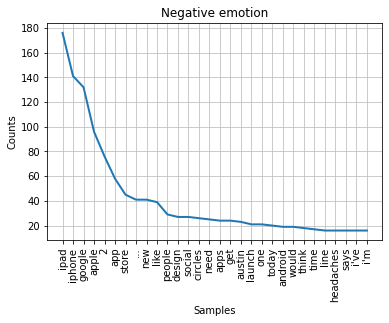

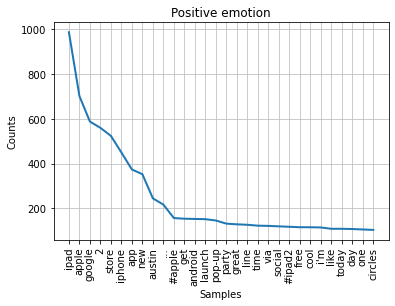

In [76]:
for ax, emotion in zip(axes, sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()):
    tweet = sentiment_df.loc[sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'] == emotion,
                            'no_stops']
    tweet = tweet.str.join(' ')
    tweet = ' '.join(tweet)
    tweet = tweet.split(' ')
    fdist = FreqDist(tweet)
    fdist.plot(30, title=emotion)

We can also create word clouds for positive and negative tweets as a fun way to see the most frequent words in both classes; the bigger the word, the more frequent it showed up in our data.

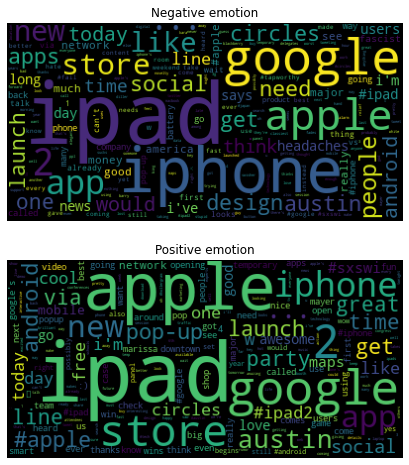

In [77]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for ax, emotion in zip(axes, sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].unique()):
    tweet = sentiment_df.loc[sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'] == emotion,
                            'no_stops']
    tweet = tweet.str.join(' ')
    tweet = ' '.join(tweet)
    tweet = tweet.split(' ')
    fdist = FreqDist(tweet)
    wordcloud = WordCloud().generate_from_frequencies(fdist)

    ax.imshow(wordcloud)
    ax.set_title(emotion)
    ax.axis('off')
plt.show()

## Preprocessing

Before we can continue on to predictive modeling, I would also like to lemmatize our text data, which changes variants of words down to a root word through linguistic mappings within the function (i.e. "running" and "ran" would become "run"). This way, we can try to reduce the amount of the same words but with different suffixes that our model takes in.

In [22]:
lemmatizer = WordNetLemmatizer()
sentiment_df['lemmatized'] = sentiment_df['no_stops'].apply(lambda x:[lemmatizer.lemmatize(w) for w in x])
sentiment_df['lemmatized']

0       [@wesley83, 3g, iphone, 3, hr, tweeting, #rise...
1       [@jessedee, know, @fludapp, awesome, ipad, iph...
2               [@swonderlin, wait, #ipad, 2, also, sale]
3       [hope, year's, festival, crashy, year's, iphon...
4       [@sxtxstate, great, stuff, fri, marissa, mayer...
                              ...                        
8706    [pr, guy, convinced, switch, back, iphone, gre...
8708    [papyrus, ..., sort, like, ipad, nice, lol, la...
8709    [diller, say, google, tv, might, run, playstat...
8713    [i've, always, used, camera, iphone, b, c, ima...
8716                                   [ipad, everywhere]
Name: lemmatized, Length: 3414, dtype: object

In [23]:
sentiment_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tokens,lower_tokens,no_stops,lemmatized
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[@wesley83, 3g, iphone, 3, hrs, tweeting, #ris...","[@wesley83, 3g, iphone, 3, hr, tweeting, #rise..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, awesome, ipad, iph...","[@jessedee, know, @fludapp, awesome, ipad, iph..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, sale]","[@swonderlin, wait, #ipad, 2, also, sale]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[hope, year's, festival, crashy, year's, iphon...","[hope, year's, festival, crashy, year's, iphon..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, marissa, mayer...","[@sxtxstate, great, stuff, fri, marissa, mayer..."


Using the lemmatized text data, we can then split the dataset into training and test sets before we start fitting our models.

In [24]:
X = sentiment_df['lemmatized'].str.join(' ')
y = sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [25]:
X_train

184                                    #ipad 2 take video
210     hobo shotgun video game coming ipad iphone use...
6906    #tech even begin #apple win past week there's ...
857     think might go weekend without seeing ipad cas...
4690    andrew k prx equates homogeneity apple ecosyst...
                              ...                        
5277                    apple school marketing expert via
7873    woohoo go game launch do-it-yourself iphone sc...
4240    left brain search google right brain search x ...
2703    joined heaving river flow see marissa mayer go...
3259    y'all seen temp apple store going downtown wou...
Name: lemmatized, Length: 2731, dtype: object

Because our classes are imbalanced, I use [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) from the imblearn library to oversample the data. By passing the `'minority'` argument into SMOTE, it synthesizes new entries based the minority class and adds them to the training dataset. We only want to perform oversampling on the training dataset to train our models, as performing it on our test model would affect the integrity of our holdout data and the validity of our model [[source]](https://stackoverflow.com/a/48810493).

In [44]:
sentiment_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

In [27]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train, y_train)
X_train_vec = tfidf_vectorizer.transform(X_train)
y_train_vec = tfidf_vectorizer.transform(y_train)

smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_vec, y_train_vec)

In [46]:
X_train_resampled.shape

(4598, 4761)

In [28]:
X_train_resampled.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Analysis

In [62]:
def cross_validation(pipeline, X_train, y_train):
    """
    Fits training data onto a pipeline model and returns 
    an array of cross-validated accuracy scores and the 
    overall average of those scores.
    """
    scores = cross_val_score(pipeline, X_train, y_train)
    agg_score = np.mean(scores)
    print(scores)
    print(agg_score)

### Random Forest

The first model I fit our data on will use the [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier. I chose to use this model first because of its performance in a [previous analysis](https://github.com/nancyho83/Tanzania_Water_Well_Analysis) of mine, and wanted to see if it would also perform well here.

In addition to the classifier, we also initialize a [TF-IDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to convert our text data into vectors that our models will be able to recognize and process. To streamline model creation and prevent data leakage, we create a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html) including the text vectorizer, classifier model, and SMOTE to oversample the training data before fitting the model to resolve the class imbalance.

In [60]:
rf_model = RandomForestClassifier()
tfidf_vectorizer = TfidfVectorizer()

rf_pipe = make_pipeline(tfidf_vectorizer, smote, rf_model)

cross_validation(rf_pipe, X_train, y_train)

[0.87934186 0.88278388 0.88095238 0.87362637 0.86630037]
0.8766009736759279


To evaluate the performance of our model, we perform cross validation among the training set and take the average of the scores of each fold to obtain an aggregate rating of our model. So far, it seems that this model has a good performance when predicting tweet sentiment!

In [63]:
cross_validation(rf_pipe, X_train, y_train)

[0.87202925 0.88278388 0.88278388 0.87362637 0.87179487]
0.8766036522892099


To visualize the accuracy of our model and validate it against our holdout data, we can utilize a confusion matrix to measure how well our final model can predict a tweet's sentiment based on its content. Since the cross validation function I use automatically fits the model to obtain the cross-validated scores, I refit the model here to obtain the confusion matrix.

Text(0.5, 1.0, 'Random forest confusion matrix')

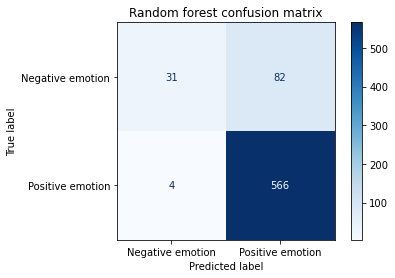

In [90]:
rf_pipe.fit(X_train, y_train)
plot_confusion_matrix(rf_pipe, X_test, y_test, cmap='Blues')
plt.title('Random forest confusion matrix')

### Naive Bayes

The next model I will use utilizes the [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) classifier, which is a variant of the Naive Bayes classifier ideal for classification problems involving discrete features like the text data we are working with (although I will still be using vectorized text data when fitting this model).

In [64]:
mnb_model = MultinomialNB()
tfidf_vectorizer = TfidfVectorizer()

mnb_pipe = make_pipeline(tfidf_vectorizer, smote, mnb_model)

[0.79159049 0.82783883 0.82051282 0.79487179 0.78571429]
0.8041056445078383


Although this model performed worse than our random forest model, it still managed to perform fairly well overall.

In [79]:
cross_validation(mnb_pipe, X_train, y_train)

[0.79159049 0.82967033 0.82051282 0.81868132 0.78571429]
0.8092338496360434


Text(0.5, 1.0, 'Multinomial Naive Bayes confusion matrix')

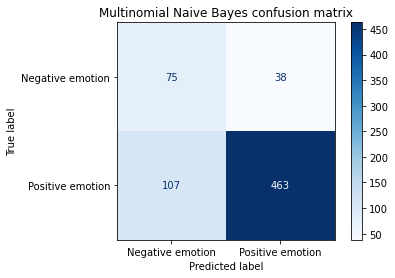

In [89]:
mnb_pipe.fit(X_train, y_train)
plot_confusion_matrix(mnb_pipe, X_test, y_test, cmap='Blues')
plt.title('Multinomial Naive Bayes confusion matrix')

### XGBoost

Our final model utilizes the XGBoost classifier from the [XGBoost](https://xgboost.readthedocs.io/en/latest/) library, and is designed to use optimized gradient boosting algorithms to create machine learning models; the XGBClassifier module that we will be using in particular accomplishes this in Python while utilizing the scikit-learn API [[XGBoost scikit-learn API documentation]](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). 

In [84]:
xgb_model = XGBClassifier(eval_metric='auc')
tfidf_vectorizer = TfidfVectorizer()

xgb_pipe = make_pipeline(tfidf_vectorizer, smote, xgb_model)

This model performs almost as well as our random forest model, showing similar cross-validated scores but returning a very slightly lower average score.

In [85]:
cross_validation(xgb_pipe, X_train, y_train)

[0.8464351  0.86996337 0.87728938 0.86446886 0.87179487]
0.8659903168129859


Text(0.5, 1.0, 'XGB boost confusion matrix')

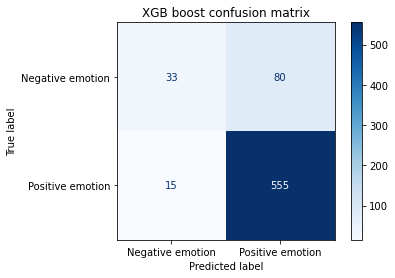

In [88]:
xgb_pipe.fit(X_train, y_train)
plot_confusion_matrix(xgb_pipe, X_test, y_test, cmap='Blues')
plt.title('XGB boost confusion matrix')

## Conclusion

Our random forest model ended up performing the best out of all our models, scoring with an accuracy of 0.87. However, all our models performed fairly well -- even our weakest model, the multinomial Naive Bayes model, didn't score much lower than our best model. As this baseline model serves as a proof of concept, we can further expand on this model using more tweet data -- and possibly other forms of customer feedback such as surveys and comments -- to come up with more ideas to improve our services and maintain and expand our consumer base.

### Next Steps

- In our raw dataset, more than half of our dataset had null values in the `emotion_in_tweet_is_directed_at` column that tells us what product the tweet was directed at, so it would not have been a good idea to look at sentiment for Apple vs Google products. In the future, I would like to perform a more detailed comparison between positive and negative tweets about products from both companies and see how they contrast.
- There were also a fair amount of tweets that were labeled as "I can't tell"; I would like to investigate those entries, figure out why they were labeled as such, and possibly integrate them into our dataset.
- Instead of oversampling our training data to compensate for the lack of negative tweets, we can integrate other datasets containing more negative tweets and incorporate that data into our pre-existing analysis.
- I would like to incorporate a deep learning model to evaluate our data. Not only would it serve as yet another model we can test to predict the sentiment of a tweet with based on our data we used here, but we can possibly create a sentiment analysis model that can take in Twitter data and label tweets for us to expand on our data.